Heavily leveraging example given here https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_online_wine.html

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
wine_data = load_wine()
feature_names = wine_data.feature_names

X, y = wine_data.data, wine_data.target
X_ref, X_test, y_ref, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np
import scipy

In [4]:
from alibi_detect.cd import MMDDriftOnline

/opt/anaconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ert = 50
window_size = 10
cd = MMDDriftOnline(X_ref, ert, window_size, backend='pytorch', n_bootstraps=2500)

No GPU detected, fall back on CPU.


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:00<00:00, 19.63it/s]


In [6]:
def time_run(cd, X, window_size):
    n = X.shape[0]
    perm = np.random.permutation(n)
    t = 0
    cd.reset_state() #updated based on git issue!
    while True:
        #print(t%n)
        pred = cd.predict(X[perm[t%n]])
        if pred['data']['is_drift'] == 1:
            return t
        else:
            t += 1

In [7]:
n_runs = 4
#times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]
times_h0 = [time_run(cd, X_ref, window_size) for _ in range(n_runs)] #changed to X_ref just to run a test, change back!


print(f"Average run-time under no-drift: {np.mean(times_h0)}")
_ = scipy.stats.probplot(np.array(times_h0), dist=scipy.stats.geom, sparams=1/ert, plot=plt)

In [ ]:
cd.reset_state()

In [ ]:
X.shape

(178, 13)

In [ ]:
n = X.shape[0]
perm = np.random.permutation(n)
t = 0
# cd.reset()
# while True:
#     pred = cd.predict(X[perm[t%n]])
#     if pred['data']['is_drift'] == 1:
#         return t
#     else:
#         t += 1

In [ ]:
n = X.shape[0]
perm = np.random.permutation(n)
t = 0

In [ ]:
cd.predict(X[perm[6%n]])

{'data': {'is_drift': 0,
  'distance': None,
  'p_val': None,
  'threshold': 0.13158504327284265,
  'time': 1,
  'ert': 50,
  'test_stat': -0.05757220772336902},
 'meta': {'name': 'MMDDriftOnlineTorch',
  'online': True,
  'data_type': None,
  'version': '0.11.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [ ]:
import pandas as pd

In [ ]:
df_X_ref = pd.DataFrame(X_ref)

In [ ]:
df_X_test = pd.DataFrame(X_test)

<Axes: >

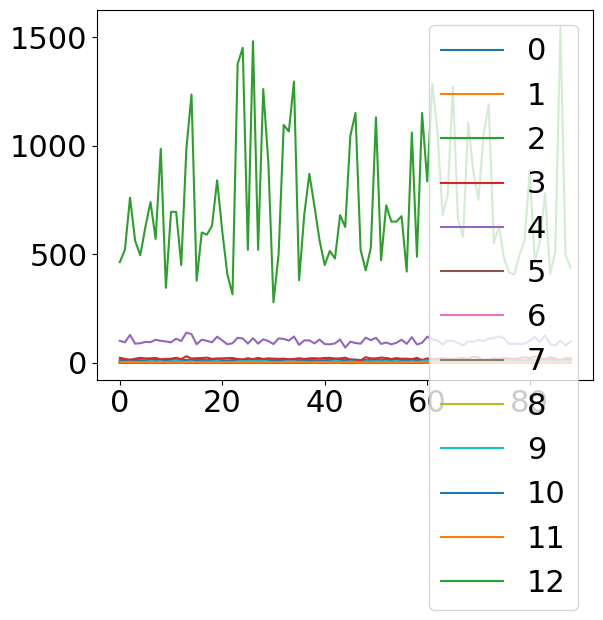

In [ ]:
df_X_ref.plot()

In [ ]:
df_X_test.plot()

In [ ]:
df_X_test.apply(lambda x: cd.predict(x.values))

In [ ]:
df_X_test.head().apply(lambda x: type(x.values))

In [ ]:
df_X_test.apply(lambda x: cd.predict(x.values)['data']['is_drift'], axis=1).plot(marker='o', linewidth=0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
df_X_test.plot(ax=ax, label='_nolegend_')
df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1).plot(kind='bar', ax=ax, color='orange', alpha=0.5, label='Drift')
ax.set_xlabel('t+n')
ax.set_ylabel('arb. units')
ax.legend(loc='upper right', shadow=True)
plt.legend()

In [ ]:
#### SIMULATE DRIFT DETECTION AND PLOT - USE A LAMBDA
fig, ax = plt.subplots(figsize=(20,10))

cols = ["_" + str(col) for col in df_X_test.columns]
cols[-1] = 'Features'
df_X_test.columns = cols

df_X_test.plot(ax=ax)
ax.set_xlabel('Time (arb. units)')
ax.set_ylabel('arb. units')

ax2= df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1).plot(
    kind='bar', 
    ax=ax,
    color='orange', 
    alpha=0.5, 
    label='Drift')

ax2.legend(loc='upper right', shadow=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))

In [ ]:
#assume X=np.array
def simulate_drift_detection(cd, X):
    drift_detected = []
    if len(X)>100:
        return 0
    else:
        for row in X:
            cd.reset()
            drift_detected.append(cd.predict(row)['data']['is_drift'])
        return drift_detected

In [ ]:
pd.Series(simulate_drift_detection(cd, X_test)).plot()

In [ ]:
df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1)

In [ ]:
df_X_test_drift_detections = df_X_test.apply(lambda x: cd.predict(x.values)['data']['is_drift'], axis=1)`

In [ ]:
df_X_test.merge(df_X_test_drift_detections.to_frame(), left_index=True, right_index=True).plot()

In [ ]:
df_X_test_drift_detections.plot(kind='bar')

In [ ]:
df_X_test.normalize()